<a href="https://colab.research.google.com/github/Tyler-Pickett/Transformer_with_Attention/blob/main/Transformer_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/MyDrive/Colab_Notebooks/')

In [2]:
import pathlib
# specific import pathway necessary, situational
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pickle
import random
import re
import unicodedata

import matplotlib.pyplot as plt
from prompt_toolkit import output
from keras.layers import TextVectorization
import numpy as np

# Dataset from Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname = "fra-eng.zip",
    origin = "http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract = True
)

# Show file's download location
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)


/root/.keras/datasets/fra.txt


In [3]:
text_file

PosixPath('/root/.keras/datasets/fra.txt')

In [4]:
open(text_file)

<_io.TextIOWrapper name='/root/.keras/datasets/fra.txt' mode='r' encoding='UTF-8'>

In [5]:
def normalize(line):
  "Normalize a line of text and split into two at the tab character"
  line = unicodedata.normalize("NFKC", line.strip().lower())
  line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
  line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
  eng, fra = line.split("\t")
  far = "[start] " + fra + " [end]"
  return eng, fra
  
  # Normalize each line and separate into English and French
with open(text_file) as fp:
  text_pairs = [normalize(line) for line in fp]

  #Print normalized line samples
for _ in range(8):
  print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
  pickle.dump(text_pairs, fp)
    

('tom decided to take a chance .', 'tom a décidé de prendre le risque .')
('i know that you and tom are friends .', 'je sais que tom et toi êtes amis .')
('thanks for the cup of coffee .', 'merci pour le café .')
('stop making a fool of yourself . everyone is laughing at you .', 'arrête de te donner en spectacle . tout le monde rit de toi .')
('i hate to complain .', 'je déteste me plaindre .')
('how are you getting along with your study ?', "comment tu t'en sors avec tes études  ? ")
('he was hit by a car and died instantly .', 'il a été percuté par une voiture et est mort sur le coup .')
('all the prisoners escaped .', 'toutes les prisonnières se sont échappées .')


In [6]:
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)

#Distinct word counts
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
  eng_tok, fra_tok = eng.split(), fra.split()
  eng_maxlen = max(eng_maxlen, len(eng_tok))
  fra_maxlen = max(fra_maxlen, len(fra_tok))
  eng_tokens.update(eng_tok)
  fra_tokens.update(fra_tok)

print(f"Total English words: {len(eng_tokens)}")
print(f"Total French words: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English words: 14969
Total French words: 29217
Max English length: 51
Max French length: 58
167130 total pairs


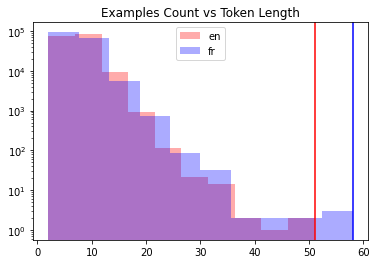

In [7]:
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)

# sentence length histogram
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log") # sentence length fits Benford's law(first-digit law, is an observation that in many real-life sets of numerical data, the leading digit is likely to be small)
plt.ylim(plt.ylim()) # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples Count vs Token Length")
plt.show()

In [8]:
# load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)

# train-tech-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer, with training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

#save for proceeding steps
with open("vectorize.pickle", "wb") as fp:
  data = {
      "train": train_pairs,
      "val": val_pairs,
      "test": test_pairs,
      "engvec_config": eng_vectorizer.get_config(),
      "engvec_weights": eng_vectorizer.get_weights(),
      "fravec_config": fra_vectorizer.get_config(),
      "fravec_weights":fra_vectorizer.get_weights(),
  }
  pickle.dump(data, fp)

In [9]:
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
  data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"] # not used, yet

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# setup for tf dataset object
def format_dataset(eng, fra):
    """ Convert English adn French sentence pair into input and target.
    Input is a dict with 'encoder_inputs' and 'decoder_inputs' keys,
    each a vector, that corresponds to English and French sentences.
    Target is a vector of the French sentence, advanced by 1 token.
    All vectors are equal length.

    Output will train transformer model; with input tensors,
    'encoder_inputs' and 'decoder_inputs', which need to be matched
    to keys in the dictionary for source variable.
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
  """To build Tesnorflow dataset for sentence pairs"""
  # to aggregate sentences
  eng_texts, fra_texts = zip(*pairs)
  # to convert aggregate sentences to a list and then create tensors
  dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
  return dataset.shuffle(2048) \
                .batch(batch_size).map(format_dataset) \
                .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f'targets.shape: {targets.shape}')
    print(f'targets[0]; {targets[0]}')

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [  10  240    8 1513   14   23  871    2    0    0    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [  14   19  214   24 5413    4   62 1132    2    0    0    0    0    0
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]; [  19  214   24 5413    4   62 1132    2    0    0    0    0    0    0
    0    0    0    0    0    0]


In [10]:
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)
 
train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used
 
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])
 
# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.
 
    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)
 
def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()
 
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
 
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [191   8 166   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [375  17 628  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
targets.shape: (64, 20)
targets[0]: [ 17 628  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


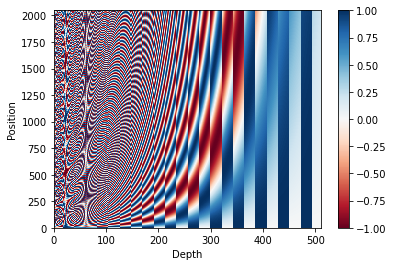

In [11]:
def positional_encoding_matrix(L, d, n=10000):
  """Create positional encoding matrix

  Arguments:
    L: Input dimension(length)
    d: Output dimension (depth), even only
    n: Constant for the sinusoidal functions
  
  Return:
    Numpy matrix of floats of dimension L -by- d. At element (k,2i)
    the value is sin(k/n^(2i/d)); while at element (k,2i+1)
    the value is cos(k/n^(21/d))
  """
  assert d % 2 == 0, "To make Output dimension an even integer"
  d2 = d//2
  P = np.zeros((L, d))
  k = np.arange(L).reshape(-1, 1)   # L column vector
  i = np.arange(d2).reshape(1, -1)  # d row vector
  denom =  np.power(n, -i/d2)       # n**(-2*i/d)
  args = k * denom                  # (L, d) matrix
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

# plot positional encoding matrix
positional_matrix = positional_encoding_matrix(L=2048, d=512)
assert positional_matrix.shape == (2048, 512)
plt.pcolormesh(positional_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
  pickle.dump(positional_matrix, fp)

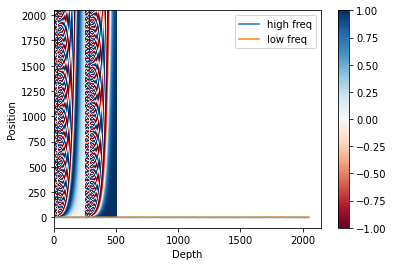

In [12]:
with open("posenc-2048-512.pickle", "rb") as fp:
  positional_matrix = pickle.load(fp)
assert positional_matrix.shape == (2048,512)
# Alternative way to plot positional matrix
plt.pcolormesh(np.hstack([positional_matrix[:, ::2], positional_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.plot(positional_matrix[:, 155], label="high freq") # ex. to check different depths in the matrix,
plt.plot(positional_matrix[:, 300], label="low freq")  # represents sine curves of different frequency
plt.legend()
plt.show()

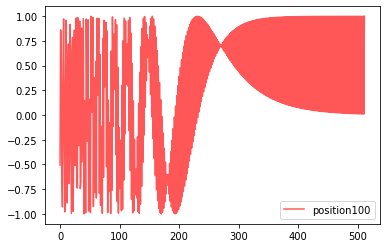

In [13]:
# to visualize one "position" of the matrix
plt.plot(positional_matrix[100], alpha=0.66, color="red", label="position100")
plt.legend()
plt.show()

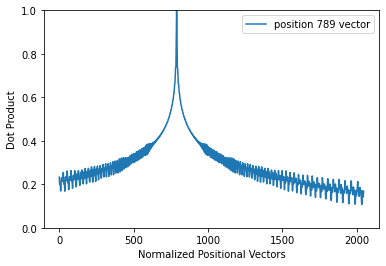

In [14]:
# to visualize the dot product between normalized positional vectors
# if the dot product is 1 the normalized vectors are identical,
# dropping quickly as they move apart

positional_matrix /= np.linalg.norm(positional_matrix, axis=1, keepdims=True)
p = positional_matrix[789] # compares position 789 vector to all vectors
dots = positional_matrix @ p
plt.plot(dots, label="position 789 vector")
plt.ylim([0, 1])
plt.xlabel("Normalized Positional Vectors")
plt.ylabel("Dot Product")
plt.legend()
plt.show()

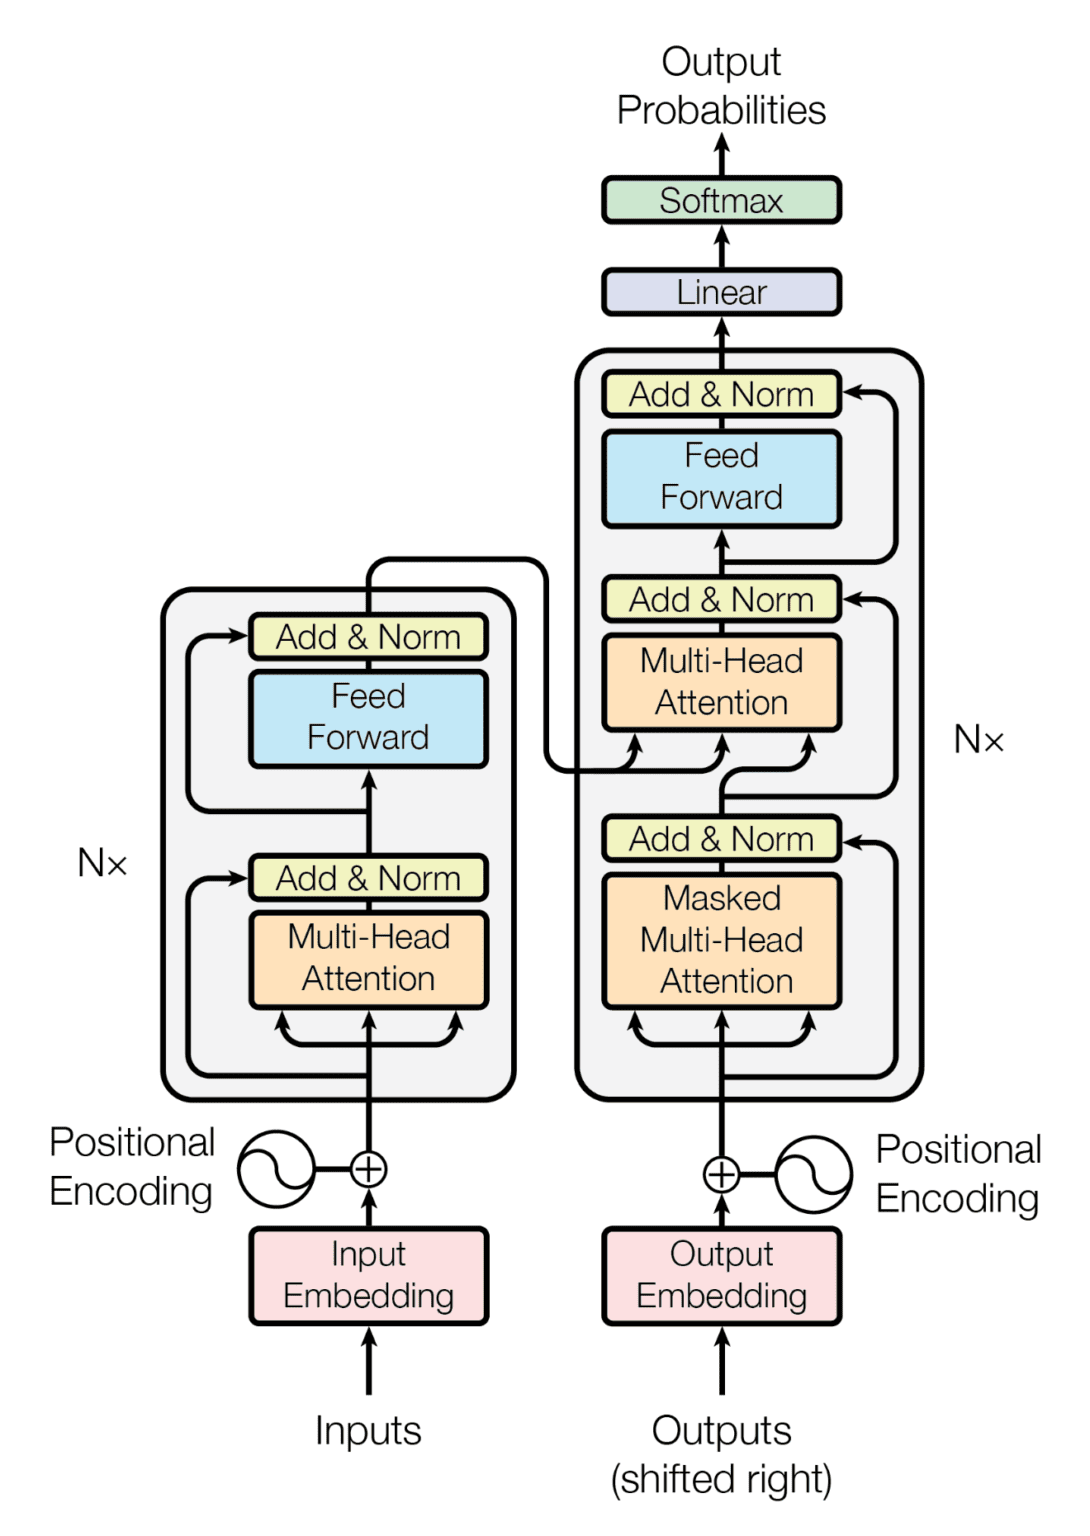

In [15]:
def positional_encoding_matrix(L, d, n=10000):
  """Create positional encoding matrix

  Arguments:
    L: Input dimension(length)
    d: Output dimension (depth), even only
    n: Constant for the sinusoidal functions
  
  Return:
    Numpy matrix of floats of dimension L -by- d. At element (k,2i)
    the value is sin(k/n^(2i/d)); while at element (k,2i+1)
    the value is cos(k/n^(21/d))
  """
  assert d % 2 == 0, "To make Output dimension an even integer"
  d2 = d//2
  P = np.zeros((L, d))
  k = np.arange(L).reshape(-1, 1)   # L column vector
  i = np.arange(d2).reshape(1, -1)  # d row vector
  denom =  np.power(n, -i/d2)       # n**(-2*i/d)
  args = k * denom                  # (L, d) matrix
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

class PositionalEmbedding(tf.keras.layers.Layer):
  """ Positional embedding layer. Tokenized input, transformed into
  embedding and returns positional encoded output.
  """
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    """
    Args:
      sequence_length: input sequence length
      vocab_size: input vocabulary size, to setup embedding matrix
      embed_dim: embedding vector size, to setup embedding matrix
    """
    super().__init__(**kwargs)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim # d model from paper
    # Token Embedding Layer: convert integer token to d-dim float vector
    self.token_embeddings = tf.keras.layers.Embedding(
      input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
    )
    # Positional Embedding Layer: a matrix of hard coded sine values
    matrix = positional_encoding_matrix(sequence_length, embed_dim)
    self.position_embeddings = tf.constant(matrix, dtype="float32")

  def call(self, inputs):
    """
    Input tokens convert into embedding vectors then
    superimposed with position vectors
    """
    embedded_tokens = self.token_embeddings(inputs)
    return embedded_tokens + self.position_embeddings

  # Layer using an Embedding layer, which can take a mask
  # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)


  def get_config(self):
    # to make, save, and load a model(using a custom layer is possible)
    config = super().get_config()
    config.update({
        "sequence_length": self.sequence,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim
    })
    return config

In [16]:
vocab_size_en = 10000
seq_length = 20

# test dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  32  240  591 ...    0    0    0]
 [   3  139 1788 ...    0    0    0]
 [   3   20   48 ...    0    0    0]
 ...
 [  10    9   70 ...    0    0    0]
 [ 164   26  535 ...    0    0    0]
 [  67   24   30 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


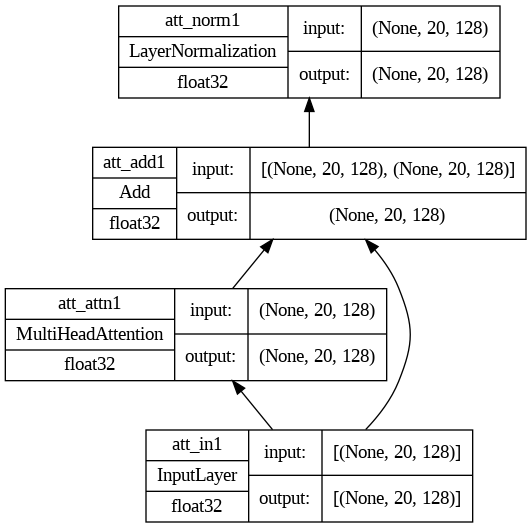

In [17]:
def self_attention(input_shape, prefix="att", mask=False, **kwargs):
  """
  Self-attention layers at transformer encoder and decoder.
  Assumes input is output from positional encoding layer.

  Args:
    prefix(str): prefix added to layer names
    masked(bool): whether or not to use casual mask. False on encoder
      and true on decoder. When True a mask will be applied, only
      letting a location have access to locations before it.
  """
  # create layers
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in1")
  attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
  norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
  add = tf.keras.layers.Add(name=f"{prefix}_add1")
  
  # functional API to connect input to output
  attout = attention(query=inputs, value=inputs, key=inputs,
                     use_causal_mask=mask)
  outputs = norm(add([inputs, attout]))
  
  # create and return model
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
  return model

seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self_attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir="BT", show_layer_activations=True)


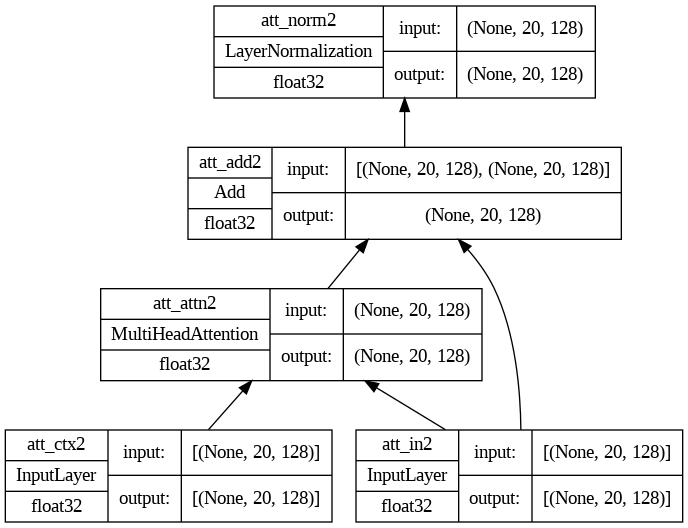

In [18]:
def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
  """
  Cross-Attention layers at transformer decoder. Assumes its input
  is the output from positional encoding layer at decoder and
  context is the final output from encoder.

  Args:
    prefix(str): A prefix added to layer names
  """

  # create layers
  context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                  name=f"{prefix}_ctx2")
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in2")
  attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
  norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
  add = tf.keras.layers.Add(name=f"{prefix}_add2")

  #functional API to connect input to output
  attout = attention(query=inputs, value=context, key=context)
  outputs = norm(add([attout, inputs]))

  #create and return model
  model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                         name=f"{prefix}_cross")
  return model

seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

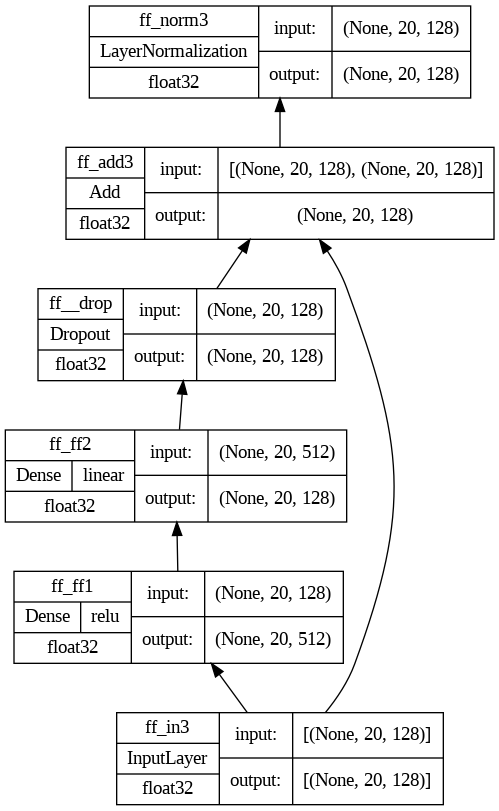

In [19]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
  """
  Feed-Forward layers at transformer encoder and decoder. Input must be the
  output from an attention layer with add & norm, the output is the output
  of one encoder or decoder block.

  Args:
    model_dim(int): Output dimension of the feed-forward layer, which is also
                    the output dimension of the encoder/decoder block
    ff_dim(int): Internal dimension of feed-forward layer
    dropout(float): Dropout rate (Randomnly selected "neurons are ignored)
    prefix(str): The prefix added to the layer names
  """

  # create layers
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in3")
  dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
  dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
  drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}__drop")
  add = tf.keras.layers.Add(name=f"{prefix}_add3")

  # functional API to connect input to output
  ffout = drop(dense2(dense1(inputs)))
  norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
  outputs = norm(add([inputs, ffout]))

  # create and return model
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
  return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

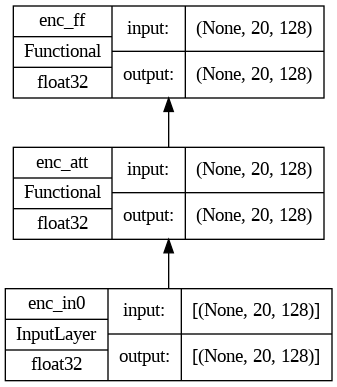

In [20]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
  """
  One encoder unit.  Input and output are the same shape, so we can
  daisy chain multipile encoder units into one larger encoder
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
      self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
      feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
  return model

seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length,key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

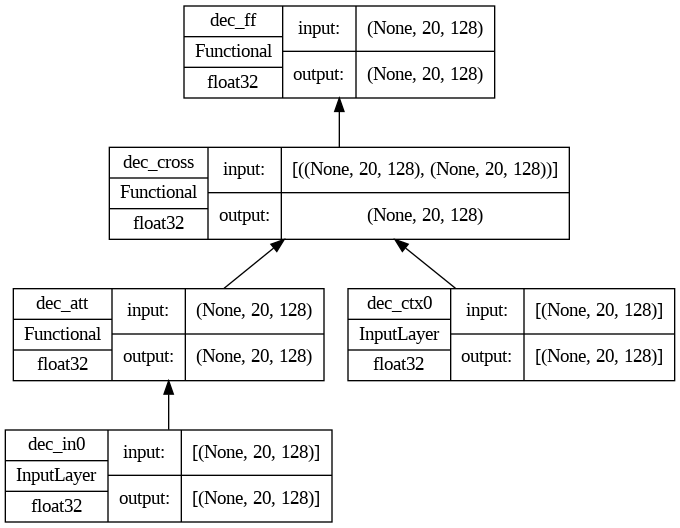

In [21]:
# building block functions from lesson 6
# from lesson 6 import self_attention, cross_attention, feed_forward

def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
  """
  One decoder unit. Input and output are the same shape, so we can
  daisy chain multiple decoder units into one larger decoder. The context
  vector is also assumed to be the same shape.
  """

  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                 name=f"{prefix}_in0")
  context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                  name=f"{prefix}_ctx0")
  
  attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                            prefix=prefix, **kwargs)
  crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                               prefix=prefix, **kwargs)
  ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
  
  x = attmodel(inputs)
  x = crossmodel([(context, x)])
  output = ffmodel(x)
  
  model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
  return model

seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir="BT", show_layer_activations=True)

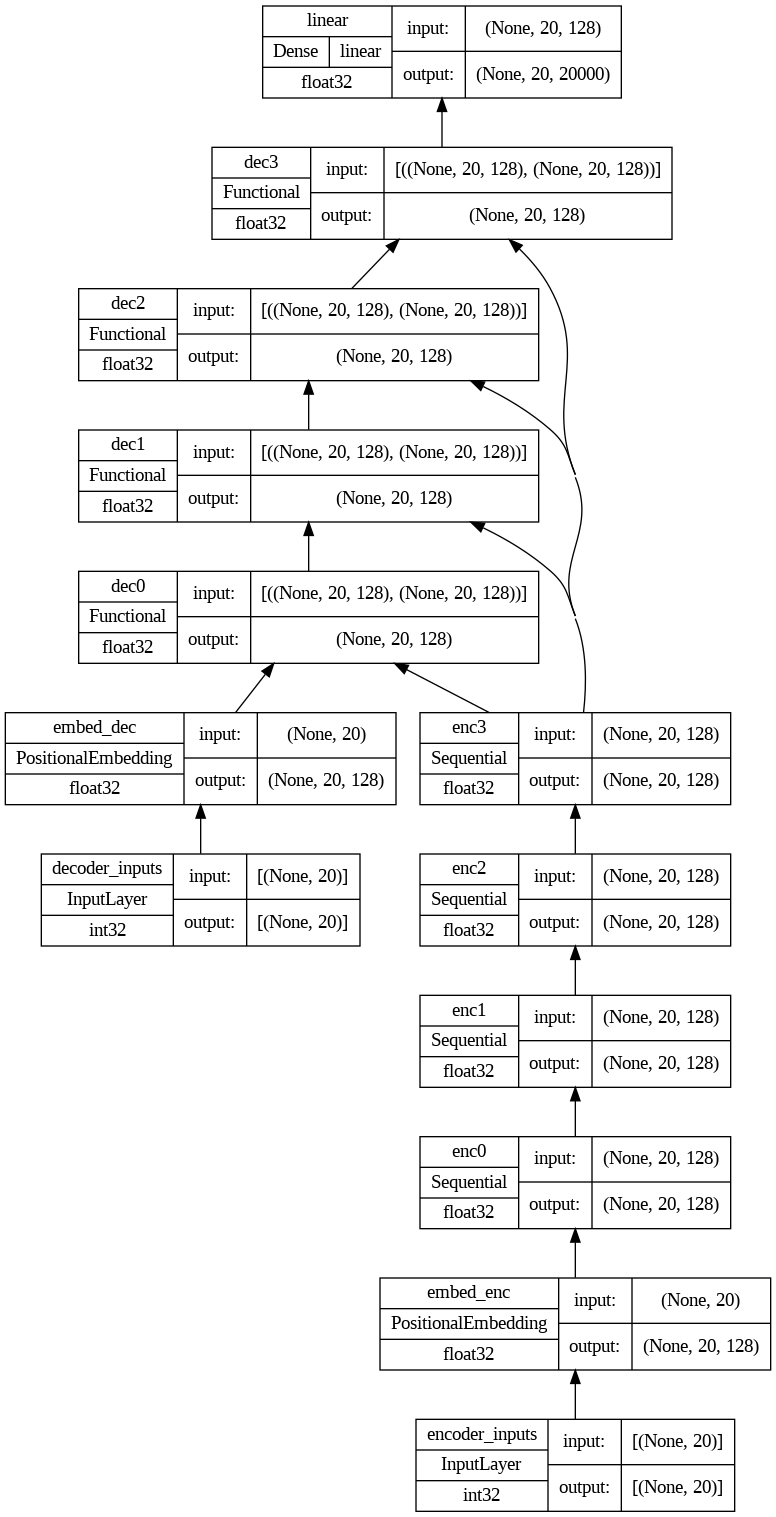

In [22]:
# positional embedding layer from 5
# from lesson_05 import PositionalEmbedding
# building block functions from 7
# from lesson_07 import encoder, decoder

def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
  embed_shape = (seq_len, key_dim) # output shape of positional embedding layer

  # set up layers
  input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                    name="encoder_inputs")
  input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                    name="decoder_inputs")
  embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
  embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
  encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                      ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                      num_heads=num_heads)
              for i in range(num_layers)]
  decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                      ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                      num_heads=num_heads)
              for i in range(num_layers)]
  final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")

  # build output
  x1 = embed_enc(input_enc)
  x2 = embed_dec(input_dec)
  for layer in encoders:
    x1 = layer(x1)
  for layer in decoders:
    x2 = layer([x2, x1])
  output = final(x2)

  # XXX keep this try-except block
  #try:
  #  del output._keras_mask
  #except AttributeError:
  #  pass
  model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
  return model

seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

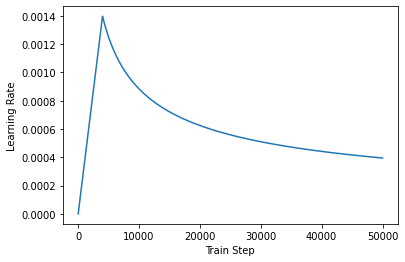

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  "Customizable learning rate for Adam optimizer"
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)
  
  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
    # to make, save, and load a model using custom layer possible0
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps,
    }
    return config

key_dim = 128
lr = CustomSchedule(key_dim) # lr = learning rate
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [24]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [25]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1

model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         